In [2]:
from keras.models import Sequential, load_model, Model
from keras.layers import Convolution2D, Dense, Flatten, Dropout, MaxPooling2D, BatchNormalization, Input
from keras.optimizers import Adam, SGD
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import CSVLogger, ModelCheckpoint, ReduceLROnPlateau
from keras.utils import np_utils
import cv2

%matplotlib inline

Using Theano backend.
WARNING (theano.sandbox.cuda): The cuda backend is deprecated and will be removed in the next release (v0.10).  Please switch to the gpuarray backend. You can get more information about how to switch at this URL:
 https://github.com/Theano/Theano/wiki/Converting-to-the-new-gpu-back-end%28gpuarray%29

Using gpu device 0: GeForce GTX 1060 6GB (CNMeM is disabled, cuDNN 5105)


In [24]:
%load_ext autoreload
%autoreload 2
import sys
paths = ['../models', '../dataset', '../util']
for path in paths:
    if path not in sys.path:
        sys.path.append(path)

from bounding_boxes import *
from data_generators import *
from preprocess import *
import dataset

bboxes = get_bounding_boxes('E:/Data/bounding_boxes')
bboxes = largest_bbox_per_image(bboxes)

train_data = dataset.train
val_data = dataset.validation

img_size = 512

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [32]:
def keras_model_conv():
    input1 = Input(shape=(3, img_size, img_size))
    
    layer = BatchNormalization(axis=1)(input1)
    layer = Convolution2D(16, 3, 3, activation='relu')(layer)
    layer = BatchNormalization(axis=1)(layer)
    layer = Convolution2D(16, 3, 3, activation='relu')(layer)
    layer = BatchNormalization(axis=1)(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    
    layer = BatchNormalization(axis=1)(layer)
    layer = Convolution2D(32, 3, 3, activation='relu')(layer)
    layer = BatchNormalization(axis=1)(layer)
    layer = Convolution2D(32, 3, 3, activation='relu')(layer)
    layer = BatchNormalization(axis=1)(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)
    
    layer = BatchNormalization(axis=1)(layer)
    layer = Convolution2D(64, 3, 3, activation='relu')(layer)
    layer = BatchNormalization(axis=1)(layer)
    layer = Convolution2D(64, 3, 3, activation='relu')(layer)
    layer = BatchNormalization(axis=1)(layer)
    layer = MaxPooling2D(pool_size=(2,2))(layer)

    layer = Flatten()(layer)
    layer = Dense(256, activation='relu')(layer)
    layer = BatchNormalization()(layer)
    label_pred = Dense(len(dataset.labels), activation='softmax', name='label_pred')(layer)
    bbox_pred = Dense(4, name='bbox_pred')(layer)
    model = Model(input=input1, output=[label_pred, bbox_pred])
    model.compile(loss={'label_pred': 'categorical_crossentropy', 'bbox_pred': 'mse'},
              optimizer=Adam(),
              metrics={'label_pred': ['categorical_crossentropy', 'accuracy'], 'bbox_pred': ['mse']})

    return model

In [33]:
model = keras_model_conv()
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
input_3 (InputLayer)             (None, 3, 512, 512)   0                                            
____________________________________________________________________________________________________
batchnormalization_17 (BatchNorm (None, 3, 512, 512)   12          input_3[0][0]                    
____________________________________________________________________________________________________
convolution2d_13 (Convolution2D) (None, 16, 510, 510)  448         batchnormalization_17[0][0]      
____________________________________________________________________________________________________
batchnormalization_18 (BatchNorm (None, 16, 510, 510)  64          convolution2d_13[0][0]           
___________________________________________________________________________________________

In [5]:
def rescale_gen(train_gen):
    while True:
        imgs, [labels, boxes] = next(train_gen)
        yield imgs, [labels, boxes.astype(np.float32) / imgs.shape[3]]

In [ ]:
train_gen = get_data_with_bbox_coords(train_data, 'E:/Data/train', bboxes, dataset.labels, img_size=(img_size, img_size),
                                      flip=True, shift_x=5, shift_y=5, rot_range=5, augmentation=True, batch_size=8)

val_gen = get_data_with_bbox_coords(val_data, 'E:/Data/train', bboxes, dataset.labels, augmentation=False,
                                    img_size=(img_size, img_size), batch_size=8)

train_gen = rescale_gen(train_gen)
val_gen = rescale_gen(val_gen)

[ 0.59960938  0.41601562  0.265625    0.22460938]
[1 0 0 0 0 0 0 0]


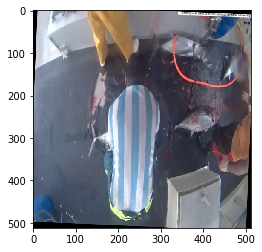

[ 0.2734375   0.40820312  0.11523438  0.21484375]
[0 0 0 0 0 1 0 0]


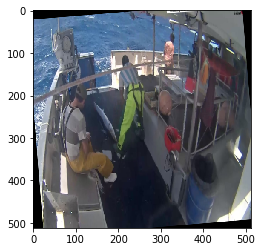

[ 0.74414062  0.62695312  0.08203125  0.21875   ]
[1 0 0 0 0 0 0 0]


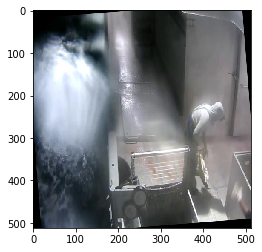

[ 0.44335938  0.73632812  0.07421875  0.09570312]
[1 0 0 0 0 0 0 0]


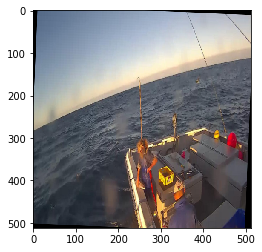

[ 0.34960938  0.72460938  0.13085938  0.21289062]
[1 0 0 0 0 0 0 0]


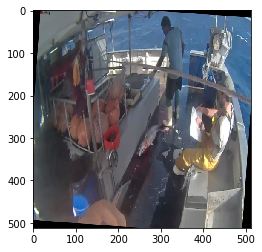

[ 0.06835938  0.35546875  0.36328125  0.26171875]
[0 0 0 0 0 0 0 1]


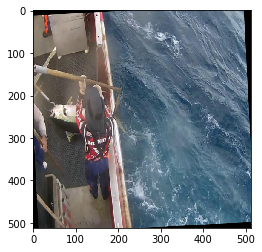

[ 0.41210938  0.69921875  0.14257812  0.26757812]
[0 0 1 0 0 0 0 0]


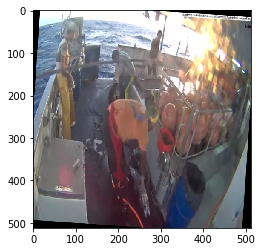

[ 0.17773438  0.69726562  0.1015625   0.18359375]
[1 0 0 0 0 0 0 0]


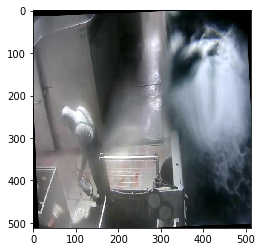

[ 0.45703125  0.4375      0.1796875   0.11132812]
[0 0 1 0 0 0 0 0]


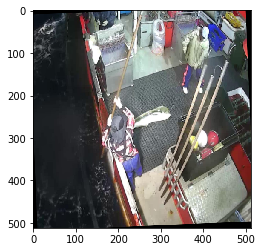

[ 0.671875    0.40625     0.04882812  0.14648438]
[1 0 0 0 0 0 0 0]


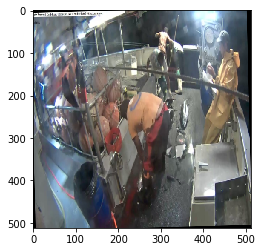

[ 0.421875   0.546875   0.09375    0.1640625]
[1 0 0 0 0 0 0 0]


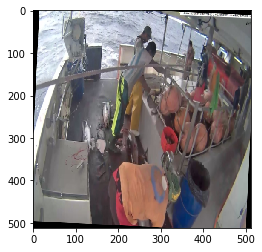

[ 0.25390625  0.03320312  0.27929688  0.27734375]
[0 1 0 0 0 0 0 0]


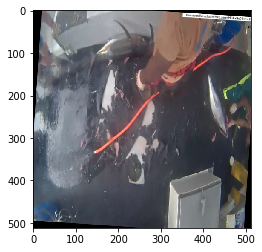

[ 0.78320312  0.          0.20703125  0.35742188]
[0 0 0 0 1 0 0 0]


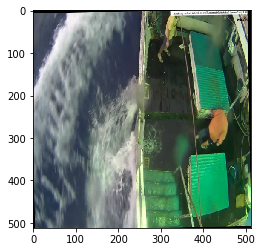

[ 0.29101562  0.38671875  0.0703125   0.12890625]
[1 0 0 0 0 0 0 0]


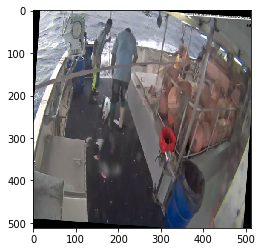

[ 0.54296875  0.42578125  0.37304688  0.45117188]
[0 0 0 0 0 0 0 1]


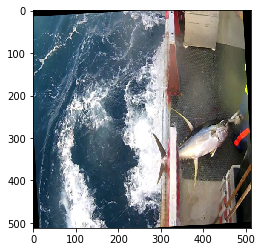

[ 0.40625     0.578125    0.11914062  0.21875   ]
[1 0 0 0 0 0 0 0]


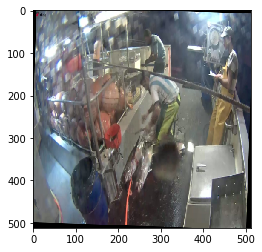

[ 0.52734375  0.32421875  0.31445312  0.24414062]
[0 0 0 0 0 0 0 1]


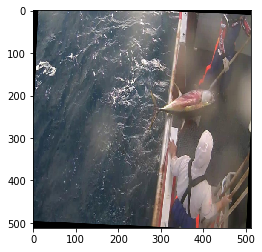

[ 0.17578125  0.44921875  0.1484375   0.13085938]
[1 0 0 0 0 0 0 0]


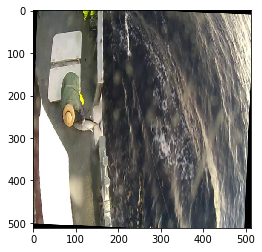

[ 0.47265625  0.56640625  0.06835938  0.15234375]
[1 0 0 0 0 0 0 0]


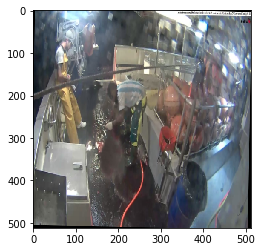

[ 0.515625    0.23046875  0.2734375   0.27539062]
[0 1 0 0 0 0 0 0]


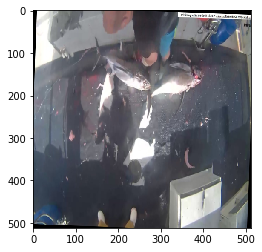

[ 0.59765625  0.76171875  0.40234375  0.21875   ]
[1 0 0 0 0 0 0 0]


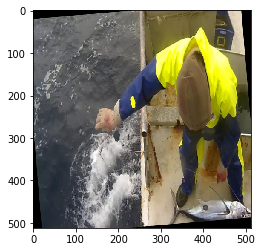

[ 0.50585938  0.51367188  0.05859375  0.20898438]
[1 0 0 0 0 0 0 0]


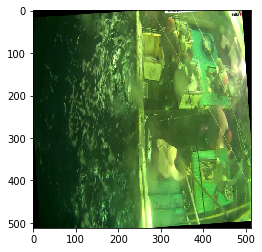

[ 0.52929688  0.5390625   0.1875      0.18945312]
[0 0 0 0 0 0 0 1]


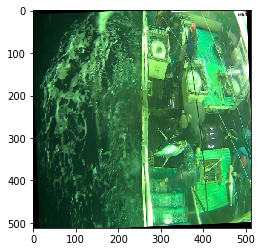

[ 0.29882812  0.51757812  0.20507812  0.19726562]
[0 0 0 0 0 0 0 1]


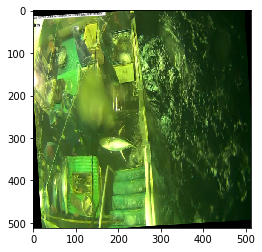

[ 0.4296875   0.52734375  0.05273438  0.203125  ]
[1 0 0 0 0 0 0 0]


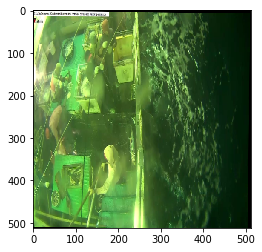

[ 0.15039062  0.12695312  0.22265625  0.15625   ]
[0 1 0 0 0 0 0 0]


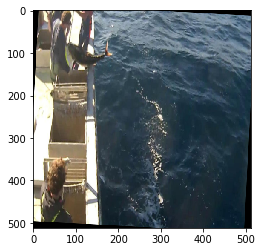

[ 0.19335938  0.11914062  0.47070312  0.49414062]
[0 0 0 0 0 0 0 1]


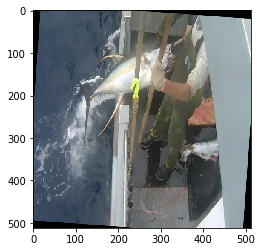

[ 0.86132812  0.01953125  0.13867188  0.26953125]
[0 0 0 0 1 0 0 0]


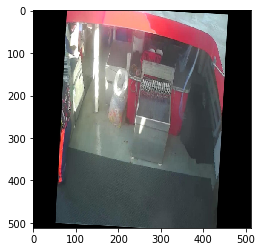

[ 0.36328125  0.72070312  0.39648438  0.26757812]
[1 0 0 0 0 0 0 0]


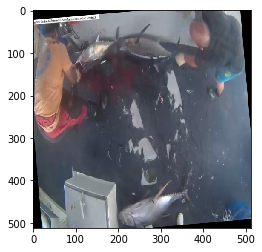

[ 0.77539062  0.          0.21679688  0.32226562]
[0 0 0 0 1 0 0 0]


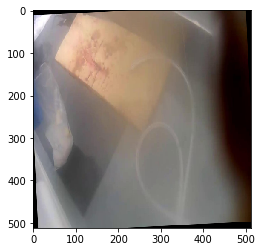

[ 0.13476562  0.1171875   0.18554688  0.33984375]
[0 0 0 0 0 0 0 1]


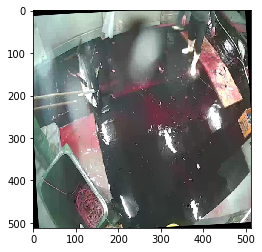

[ 0.57226562  0.40039062  0.1015625   0.10351562]
[1 0 0 0 0 0 0 0]


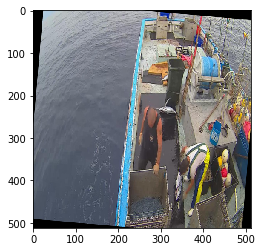

In [28]:
imgs, [labels, boxes] = next(train_gen)
for img, label, box in zip(imgs, labels, boxes):
    plt.imshow(img.transpose(1, 2, 0) + 0.5)
    print box
    print label
    plt.show()

In [ ]:
csv_logger = CSVLogger('run4_adam.csv')
lr_plateau = ReduceLROnPlateau(monitor='val_loss', patience=1, verbose=1, factor=0.5)
checkpoint = ModelCheckpoint(filepath='E:/Models/mtl_256/model.{epoch:02d}-{val_loss:.2f}.hdf5',
                             verbose=1, save_best_only=True)

model.fit_generator(train_gen, samples_per_epoch=len(train_data),
                    nb_epoch=100, verbose=1,
                    callbacks=[csv_logger, lr_plateau, checkpoint],
                    validation_data=val_gen, nb_val_samples=len(val_data))

Epoch 1/100
3016/3021 [============================>.] - ETA: 0s - loss: 1.9726 - label_pred_loss: 1.5820 - bbox_pred_loss: 0.3906 - label_pred_categorical_crossentropy: 1.5820 - label_pred_acc: 0.4665 - bbox_pred_mean_squared_error: 0.3906

d:\anaconda\envs\python2\lib\site-packages\keras\engine\training.py:1569: UserWarning: Epoch comprised more than `samples_per_epoch` samples, which might affect learning results. Set `samples_per_epoch` correctly to avoid this warning.
  warnings.warn('Epoch comprised more than '


Epoch 00000: val_loss improved from inf to 1.17700, saving model to E:/Models/mtl_256/model.00-1.18.hdf5
3024/3021 [==============================] - 319s - loss: 1.9700 - label_pred_loss: 1.5800 - bbox_pred_loss: 0.3900 - label_pred_categorical_crossentropy: 1.5800 - label_pred_acc: 0.4673 - bbox_pred_mean_squared_error: 0.3900 - val_loss: 1.1770 - val_label_pred_loss: 0.9845 - val_bbox_pred_loss: 0.1925 - val_label_pred_categorical_crossentropy: 0.9845 - val_label_pred_acc: 0.6539 - val_bbox_pred_mean_squared_error: 0.1925
Epoch 2/100
3024/3021 [==============================] - 305s - loss: 1.0719 - label_pred_loss: 0.9518 - bbox_pred_loss: 0.1201 - label_pred_categorical_crossentropy: 0.9518 - label_pred_acc: 0.6687 - bbox_pred_mean_squared_error: 0.1201 - val_loss: 0.6692 - val_label_pred_loss: 0.6001 - val_bbox_pred_loss: 0.0691 - val_label_pred_categorical_crossentropy: 0.6001 - val_label_pred_acc: 0.7855 - val_bbox_pred_mean_squared_error: 0.0691
Epoch 3/100
3024/3021 [========

3024/3021 [==============================] - 304s - loss: 0.1363 - label_pred_loss: 0.1206 - bbox_pred_loss: 0.0158 - label_pred_categorical_crossentropy: 0.1206 - label_pred_acc: 0.9696 - bbox_pred_mean_squared_error: 0.0158 - val_loss: 0.2420 - val_label_pred_loss: 0.2273 - val_bbox_pred_loss: 0.0146 - val_label_pred_categorical_crossentropy: 0.2273 - val_label_pred_acc: 0.9421 - val_bbox_pred_mean_squared_error: 0.0146
Epoch 23/100
3016/3021 [============================>.] - ETA: 0s - loss: 0.1459 - label_pred_loss: 0.1305 - bbox_pred_loss: 0.0153 - label_pred_categorical_crossentropy: 0.1305 - label_pred_acc: 0.9609 - bbox_pred_mean_squared_error: 0.0153
Epoch 00022: reducing learning rate to 6.25000029686e-05.
Epoch 00022: val_loss did not improve
3024/3021 [==============================] - 303s - loss: 0.1459 - label_pred_loss: 0.1305 - bbox_pred_loss: 0.0153 - label_pred_categorical_crossentropy: 0.1305 - label_pred_acc: 0.9610 - bbox_pred_mean_squared_error: 0.0153 - val_loss

3024/3021 [==============================] - 301s - loss: 0.0977 - label_pred_loss: 0.0834 - bbox_pred_loss: 0.0143 - label_pred_categorical_crossentropy: 0.0834 - label_pred_acc: 0.9759 - bbox_pred_mean_squared_error: 0.0143 - val_loss: 0.2180 - val_label_pred_loss: 0.2053 - val_bbox_pred_loss: 0.0127 - val_label_pred_categorical_crossentropy: 0.2053 - val_label_pred_acc: 0.9461 - val_bbox_pred_mean_squared_error: 0.0127
Epoch 44/100
3016/3021 [============================>.] - ETA: 0s - loss: 0.0941 - label_pred_loss: 0.0802 - bbox_pred_loss: 0.0139 - label_pred_categorical_crossentropy: 0.0802 - label_pred_acc: 0.9788 - bbox_pred_mean_squared_error: 0.0139
Epoch 00043: reducing learning rate to 4.76837180852e-10.
Epoch 00043: val_loss did not improve
3024/3021 [==============================] - 299s - loss: 0.0940 - label_pred_loss: 0.0800 - bbox_pred_loss: 0.0139 - label_pred_categorical_crossentropy: 0.0800 - label_pred_acc: 0.9788 - bbox_pred_mean_squared_error: 0.0139 - val_loss

3024/3021 [==============================] - 329s - loss: 0.1016 - label_pred_loss: 0.0875 - bbox_pred_loss: 0.0140 - label_pred_categorical_crossentropy: 0.0875 - label_pred_acc: 0.9755 - bbox_pred_mean_squared_error: 0.0140 - val_loss: 0.2175 - val_label_pred_loss: 0.2049 - val_bbox_pred_loss: 0.0126 - val_label_pred_categorical_crossentropy: 0.2049 - val_label_pred_acc: 0.9434 - val_bbox_pred_mean_squared_error: 0.0126
Epoch 65/100
  24/3021 [..............................] - ETA: 3897s - loss: 0.1085 - label_pred_loss: 0.0945 - bbox_pred_loss: 0.0141 - label_pred_categorical_crossentropy: 0.0945 - label_pred_acc: 0.9583 - bbox_pred_mean_squared_error: 0.0141

In [34]:
model.load_weights('E:/Models/mtl_512/model.09-0.20.hdf5')

In [7]:
batch_size=16
test_files_stg1 = glob.glob('E:/Data/test_stg1/*.jpg')
N = len(test_files_stg1)
print 'found %d files' % N
test_gen = get_test_data(test_files_stg1, img_size=(img_size,img_size), batch_size=batch_size)
n_batches = int(np.ceil(N / float(batch_size)))
preds_test_stg1, _ = model.predict_generator(test_gen, val_samples=n_batches*batch_size)
print preds_test_stg1.shape


found 1000 files
(1008L, 8L)


In [35]:
batch_size=16
train_files = glob.glob('E:/Data/train/*/*.jpg')
N = len(train_files)
print 'found %d files' % N
test_gen = get_test_data(train_files, img_size=(img_size,img_size), batch_size=batch_size)
n_batches = int(np.ceil(N / float(batch_size)))
preds_train, _ = model.predict_generator(test_gen, val_samples=n_batches*batch_size)
print preds_train.shape


found 3777 files
(3792L, 8L)


In [36]:
with open('512_train.csv', 'w') as sub_file:
    sub_file.write('image,ALB,BET,DOL,LAG,NoF,OTHER,SHARK,YFT\n')
    for img, pred in zip(train_files, preds_train):
        csv = '%s,%s\n' % (os.path.basename(img), ','.join([str(f) for f in pred]))
        sub_file.write(csv)

In [24]:
model.evaluate_generator(val_gen, val_samples=1000)

[0.20874070198762984,
 0.19386851716609227,
 0.014872184496313806,
 0.19386851716609227,
 0.94543650793650791,
 0.014872184481530909]

In [31]:
import h5py
with h5py.File('E:/Models/mtl_512/model.09-0.20.hdf5') as f:
    print f['model_weights']['dense_1']['dense_1_W']

<HDF5 dataset "dense_1_W": shape (230400, 256), type "<f4">


In [22]:
m = load_model('E:/Models/mtl_512/model.09-0.20.hdf5')

TypeError: unhashable type: 'list'